In [40]:
# Plot ua
# Use kernel geomet-ua 
# Smith Dec 2025. Michael.Smith2@nrcan-rncan.gc.ca
# Retrieves and plots observed/fx soundings from UW and ECCC
# We don't use the ECCC observed UA because of missing data issues
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import SkewT, add_timestamp, Hodograph
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from datetime import datetime, timedelta 


# To-do:
# Add an additional check for when observed soundings are requested, and return an error if the station ID is not valid for UW data
# Add summer option that will:
#   Add shading for CAPE and CIN
#   Add calculations to the mix and figure out where to plot them. See https://projectpythia.org/metpy-cookbook/notebooks/skewt/sounding-calculations/
# For some other layout and examples see https://unidata.github.io/MetPy/latest/examples/Advanced_Sounding_With_Complex_Layout.html#sphx-glr-examples-advanced-sounding-with-complex-layout-py 


In [41]:
# User options
# List of stations for fx: https://dd.weather.gc.ca/20251223/WXO-DD/vertical_profile/doc/station_list_for_vertical_profile.txt
# List of stations for obs can be found at: https://weather.uwyo.edu/upperair/sounding_legacy.html. 
stn_id = 'cyxy' # See above. Must be the WMO identifier for UW data, and the ICAO airport code for fx data from ECCC.
date = '20251231'  # YYYYMMDD in UTC
hour = '00'  # HH in UTC. For Canadian sites only 00 and 12 are generally available, while some US sites may have 06 and 18 during the summer convective season.
skew_type = 'fx' # 'obs' or 'fx'
zoom = False # True for zoomed in lower atmosphere plot, False for full profile

# ----- you normally don't need to change anything below this line -----

# Check on inputs and exit if invalid
if skew_type.lower() not in ['obs', 'fx']:
    raise ValueError("skew_type must be either 'obs' or 'fx'")

if hour not in ['00','06', '12', '18']:
    raise ValueError("hour must be either '00', '06', '12' or '18'")

date_test = pd.to_datetime(date, format='%Y%m%d', utc=True)  # will raise error if invalid
if not (date_test <= pd.Timestamp.utcnow().normalize()):
    raise ValueError("date must be in the past or present (UTC)")
elif skew_type.lower() == 'fx' and (date_test + pd.Timedelta(days=30)) < (pd.Timestamp.utcnow().normalize() ):
    raise ValueError("Forecast soundings are only available from Datamart for the past 30 days")

# Assuming all is good to this point, read in the station data file and pull the station info for further use
stations = pd.read_csv("station_data.csv")

# Match stn_id to either wmo_id (all digits) or iata_code (contains letters) and pull the other station properties
stn_id_str = str(stn_id).strip()
if stn_id_str.isdigit():
    matched = stations[stations['wmo_id'].astype('Int32') == int(stn_id_str)]
    match_type = 'WMO ID'
else:
    matched = stations[stations['iata_code'].str.upper() == stn_id_str.upper()]
    match_type = 'IATA/ICAO code'

if not matched.empty:
    stn_lat = matched.loc[:,'lat'].astype('float').values[0]
    stn_lon = matched.loc[:,'lon'].astype('float').values[0]
    stn_elev = matched.loc[:,'elev_m'].astype('int32').values[0]
    stn_mod_elev = matched.loc[:,'rdps_elev_m'].astype('int32').values[0]
    stn_name = matched.loc[:,'name'].astype('string').values[0]
    stn_upperair_obs = matched.loc[:,'upperair_obs'].astype('bool').values[0]
    stn_iata_code = matched.loc[:,'iata_code'].astype('string').values[0]
    stn_wmo_id = matched.loc[:,'wmo_id'].astype('Int32').values[0]
else:
    print(f"No station found for {match_type} {stn_id_str}. Will try to proceed with data retrieval anyway.")


In [42]:
# Build a URL to grab the csv output from UW 
def get_uw_ua(date, hour, stn_id):

    # URL format for UW csv observed UA is
    # https://weather.uwyo.edu/wsgi/sounding?datetime=2025-12-23%2012:00:00&id=71964&type=TEXT:CSV
    date_formatted = f'{date[0:4]}-{date[4:6]}-{date[6:8]}'
    url = f'https://weather.uwyo.edu/wsgi/sounding?datetime={date_formatted}%20{hour}:00:00&id={stn_id}&type=TEXT:CSV'
    return url


# Build a URL to get data from ECCC
def get_eccc_ua(date, hour, stn_id):

    # URL format for ECCC csv forecast UA is
    # https://dd.weather.gc.ca/20251223/WXO-DD/vertical_profile/forecast/csv/ProgTephi_12_71964.csv
    url = f'https://dd.weather.gc.ca/{date}/WXO-DD/vertical_profile/forecast/csv/ProgTephi_{hour}_{stn_id.upper()}.csv'
    return url


# ------ reshape_uw
# Reshape the UW data into a usable df
def reshape_uw_df(df_raw):
   
    # Rename columns as required
    df_raw = df_raw.rename(columns={'geopotential height_m':'geopotential height_dm'})
   
    # Convert non-numeric data to NaN in key columns
    key_cols = ['pressure_hPa', 'temperature_C', 'dew point temperature_C', 'wind speed_m/s', 'wind direction_degree']
    for col in key_cols:
        if col in df_raw.columns:
            df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')

    df_raw['wind speed_kmh'] = df_raw['wind speed_m/s'].values.astype(float) * 3.6 * units.km / units.h

    # Remove rows with NaN in key columns
    df_raw = df_raw.dropna(subset=['pressure_hPa', 'temperature_C', 'dew point temperature_C', 'relative humidity_%'])

    # Reset index
    df_all = df_raw.reset_index(drop=True)

    return df_all
    

# ----- Function to reshape the ECCC data into something usable
def reshape_eccc_df(df_raw, fx_hours=[0, 6, 12, 18, 24, 36, 48]):

    df_raw = df_raw.rename(columns={'Variable': 'variable', 'Level': 'pressure', 'Fcst_Hr': 'forecast_hour', 'Value': 'value'})
    df_raw = df_raw.sort_values(['forecast_hour', 'pressure'], ascending=[True, False])
    df_raw = df_raw[df_raw['pressure'].between(100, 1015)]

    dfs = {}
    for fh in sorted(df_raw['forecast_hour'].unique()):
        df_fh = df_raw[df_raw['forecast_hour'] == fh]
        df_pivot = df_fh.pivot(index='pressure', columns='variable', values='value').reset_index()
        df_pivot = df_pivot.sort_values('pressure')

        # Rename columns
        rename_dict = {
            'pressure': 'pressure_hPa',
            'TT': 'temperature_C',
            'WD': 'wind direction_degree',
            'UV': 'wind speed_kt',
            'ES': 'dewpoint_depression_C',
            'GZ': 'geopotential height_dm'
        }
        df_pivot = df_pivot.rename(columns=rename_dict)

        # Calculate dewpoint
        if 'temperature_C' in df_pivot.columns and 'dewpoint_depression_C' in df_pivot.columns:
            df_pivot['dew point temperature_C'] = df_pivot['temperature_C'] - df_pivot['dewpoint_depression_C']
        
        dfs[fh] = df_pivot

    # Combine all forecast hours into one df
    all_dfs = []
    for fh, df_pivot in dfs.items():
        df_pivot['forecast_hour'] = fh
        all_dfs.append(df_pivot)

    df_all = pd.concat(all_dfs, ignore_index=True)

    # Sort: first ascending forecast_hour, then descending pressure
    df_all = df_all.sort_values(['forecast_hour', 'pressure_hPa'], ascending=[True, False])

    # Convert speed from kt to km/h and geo height to dm
    df_all['wind speed_kmh'] = df_all['wind speed_kt'].astype(float) * 1.852
    df_all['geopotential height_dm'] = df_all['geopotential height_dm'].astype(float) * 10

    df_all = df_all[df_all['forecast_hour'].isin(fx_hours)]

    # Remove rows with NaN in key columns
    subset = ['pressure_hPa', 'temperature_C', 'dew point temperature_C']
    if 'relative humidity_%' in df_all.columns:
        subset.append('relative humidity_%')
    df_all = df_all.dropna(subset=subset)

    # Reset index
    df_all = df_all.reset_index(drop=True)

    return df_all
# --------------------------------------------------

# ------Function to create a name for the output figure
def make_title(site, type, date, hour, fx_hour=None, zoom=False):

    if type == "obs":
            if zoom:
                return f'{site}_{type}_{date}_{hour}UTC_skewT_loweratmos.png'
            else:
                return f'{site}_{type}_{date}_{hour}UTC_skewT.png'
    elif type == "fx":
            if zoom:
                return f'{site}_{type}_{date}_{hour}UTCp{fx_hour}_skewT_loweratmos.png'
            else:   
                return f'{site}_{type}_{date}_{hour}UTCp{fx_hour}_skewT.png'

#------------------------- Plot skew. 
# Some code is from the MetPy Cookbook: https://unidata.github.io/MetPy/latest/examples/skewt_soundings/Skew-T_Soundings.html
# df = a data frame containing pressure (ascending) and corresponding T, Td, WS, WD fields for a single sounding, or for multiple soundings if plot_type = 'all'
# skew_type: <'obs'|'fx'>. String.
# plot_type: <'single'|'all'>. String.  If 'single', the df must contain only one sounding whether it's obs or fx. If 'all', 
#             the script will overplot all soundings in the df and will not overplot sounding calculations (LCL, parcel profile)
# zoom: <True|False>. Boolean. if True, will create a zoomed-in version of the skewt focusing on the lower atmosphere. 
def plot_skewt(df, skew_type='obs', zoom=False, cutoff_elev_m = 0):

    # Remove any data below the cutoff elevation
    if cutoff_elev_m > 0.0:
        # geopotential height_dm is actually in  so don't multiply. Need to fix this.
        mask = (df['geopotential height_dm'].astype(float)) > float(cutoff_elev_m)
        df = df[mask].reset_index(drop=True)

    
    # Zoom in if zoom=True
    if zoom:
        df = df[df['pressure_hPa'] >= 500].reset_index(drop=True)
        ylim_bottom = 1000
        ylim_top = 500
        aspect = 250
        rotation = 30
        hodo = False
    else:
        ylim_bottom = 1000
        ylim_top = 100
        aspect = 80.5 #metpy default is 80.5
        rotation = 45 # Default is 30
        hodo = True

    # Populate the required series for plotting
    pres = df['pressure_hPa'].values * units.hPa
    temp = df['temperature_C'].values * units.degC
    dewpoint = df['dew point temperature_C'].values * units.degC
    
    # Generate wind barbs
    wind_speed = df['wind speed_kmh'].values * units.km / units.h
    wind_dir = df['wind direction_degree'].values * units.degrees
    u, v = mpcalc.wind_components(wind_speed, wind_dir)

    # Define the figure and rotation
    fig = plt.Figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=rotation, aspect=aspect)

    # plot t, td, wind
    skew.plot(pres, temp, 'red', label='Temperature')
    skew.plot(pres, dewpoint, 'green', label='Dew Point')

    barb_interval = np.arange(150, 1000, 50) * units('hPa')
    ix = mpcalc.resample_nn_1d(pres, barb_interval)
    skew.plot_barbs(pres[ix], u[ix], v[ix], xloc=1)

    # Calculate and plot LCL and parcel profile
    lcl_pressure, lcl_temperature = mpcalc.lcl(pres[0], temp[0], dewpoint[0])
    skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black', label='LCL')

    profile = mpcalc.parcel_profile(pres, temp[0], dewpoint[0]).to('degC')
    skew.plot(pres[1:], profile[1:], 'k', linestyle='dashed', linewidth=2, label='Parcel Profile')

    # Tweak the labels and axes
    skew.ax.set_xlabel('Temperature (°C)')
    skew.ax.set_ylabel('Pressure (hPa)')
    skew.ax.set_ylim(ylim_bottom, ylim_top)
    skew.ax.set_xlim(-55, 30)

    skew.ax.axvline(0, color='c', linestyle='--', linewidth=2, label='0°C Isotherm')

    # Plot adiabats and mixing lines
    skew.plot_dry_adiabats(t0=np.arange(200, 533, 15) * units.K, linewidth=1, alpha=0.3, color='orangered', label ='Dry Adiabats')
    skew.plot_moist_adiabats(linewidth=1, alpha=0.3, color='green', label='Moist Adiabats')
    skew.plot_mixing_lines(pressure=np.arange(1000, 99, -25) * units.hPa, linewidth=1, linestyle='dotted', color='tab:blue', label='Mixing Ratio Lines')

    # Add geopotential height labels on the primary y-axis
    target_pressures = [1000, 900, 850, 800, 750, 700, 500, 300, 200, 100]
    pres_df = df['pressure_hPa'].dropna().values
    height_df = df['geopotential height_dm'].dropna().values
    if len(pres_df) > 1 and len(height_df) > 1:
        for p in target_pressures:
            if p >= pres_df.min() and p <= pres_df.max():
                h = np.interp(p, pres_df[::-1], height_df[::-1])
                h_dm = h / 10  # Convert to decameters
                skew.ax.text(-50, p, f'{h_dm:.0f} dm', fontsize=9, color='gray', ha='left', va='center')

    # Add a hodograph
    if hodo:

        mask = height_df < 12000
        uu = u[mask]
        vv = v[mask]
        height_df_12km = height_df[mask]

        ax_hod = inset_axes(skew.ax, '35%','35%', loc=1)
        h = Hodograph(ax_hod, component_range=80)

        h.add_grid(increment=20, ls='-', lw=1.0, alpha=0.7)
        h.add_grid(increment=10, ls='--', lw=1, alpha=0.3)

        h.ax.set_box_aspect(1)
        h.ax.set_yticklabels([])
        h.ax.set_xticklabels([])
        h.ax.set_xticks([])
        h.ax.set_yticks([])
        h.ax.set_xlabel('')
        h.ax.set_ylabel('')

        plt.xticks(np.arange(0, 0, 1))
        plt.yticks(np.arange(0, 0, 1))

        for i in range(20, 160, 20):
            h.ax.annotate(str(i), (i,0), xytext=(0,2), textcoords='offset pixels', clip_on=True, fontsize=8, weight='normal', alpha=0.5, zorder=0)
        for i in range(20,160,20):
            h.ax.annotate(str(i), (0,i), xytext=(0,2), textcoords='offset pixels', clip_on=True, fontsize=8, weight='normal', alpha=0.5, zorder=0)

        h.plot_colormapped(uu, vv, c=height_df_12km, cmap='viridis', label='0-12km wind')

        #h.add_grid(increment=20)
        #h.plot_colormapped(u, v, pres, cmap='viridis')

    # Add legends
    leg_main = skew.ax.legend(loc='upper left')
    
    
    return skew

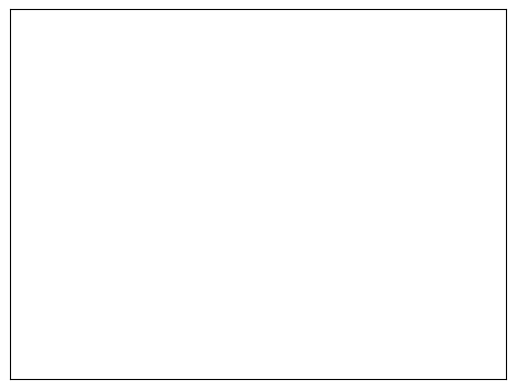

In [43]:
# Main
if __name__ == '__main__':

    # Call the appropriate functions to retrieve data and shape it prior to plotting and calcs
    if skew_type.lower() == 'obs':
        url = get_uw_ua(date, hour, stn_wmo_id)
        try:
            df_raw = pd.read_csv(url, sep=',', header=0)
        except Exception as e:
            print(f"Failed to retrieve observed data from {url}: {e}")
            raise SystemExit("Data retrieval failed")
   
        df = reshape_uw_df(df_raw)
        skew_type_title = 'Observed'

        title = f'{skew_type_title} Skew-T for {stn_name} valid {date} {hour}UTC'
        subtitle = f'{stn_iata_code}/{stn_wmo_id}, Lat: {stn_lat:.2f}°, Lon: {stn_lon:.2f}°, Elev: {stn_elev} m'

        skewt = plot_skewt(df, skew_type=skew_type, zoom=zoom, cutoff_elev_m=stn_elev)

        fx_hour = None
        
        # Move the main title up and add a subtitle below, both centered
        skewt.ax.set_title(title, fontsize='large', pad=24, loc='center')
        skewt.ax.text(0.5, 1.02, subtitle, fontsize='medium', ha='center', va='bottom', transform=skewt.ax.transAxes)

        skewt.ax.set_adjustable

        current_utc = pd.Timestamp.utcnow()
        add_timestamp(skewt.ax, time=current_utc, y=-0.10, x=0.0, ha='left', time_format='%Y-%m-%d %H:%M UTC', fontsize='medium')

        ## Add label for secondary y-axis (height)
        skewt.ax.text(1.08, 0.5, 'Wind (km/h)', transform=skewt.ax.transAxes, rotation=90, va='center', ha='left', fontsize='medium')

        skewt.ax.figure.savefig(make_title(stn_id, skew_type, date, hour, zoom=zoom))

    elif skew_type.lower() == 'fx':
        url = get_eccc_ua(date, hour, stn_iata_code)
        try:
            df_raw = pd.read_csv(url, header=1, skiprows=[2])
        except Exception as e:
            print(f"Failed to retrieve forecast data from {url}: {e}")
            raise SystemExit("Data retrieval failed")
        
        df = reshape_eccc_df(df_raw)
        skew_type_title = 'Forecast'

        model_time = pd.to_datetime(f'{date} {hour}', format='%Y%m%d %H')
        for fx_hour in sorted(df['forecast_hour'].unique()):
            df_fh = df[df['forecast_hour'] == fx_hour]
            title = f'Forecast for {stn_name}: Model init {date} {hour}UTC. Valid {model_time + pd.Timedelta(hours=fx_hour)}UTC (+{fx_hour}h)'
            subtitle = f'{stn_iata_code}/{stn_wmo_id}, Lat: {stn_lat:.2f}°, Lon: {stn_lon:.2f}°, Elev: {stn_elev} m (RDPS Model Elev: {stn_mod_elev} m)'

            skewt = plot_skewt(df_fh, skew_type=skew_type, zoom=zoom, cutoff_elev_m=stn_elev)

            # Move the main title up and add a subtitle below, both centered
            skewt.ax.set_title(title, fontsize='large', pad=24, loc='center')
            skewt.ax.text(0.5, 1.02, subtitle, fontsize='medium', ha='center', va='bottom', transform=skewt.ax.transAxes)

            skewt.ax.set_adjustable

            current_utc = pd.Timestamp.utcnow()
            add_timestamp(skewt.ax, time=current_utc, y=-0.10, x=0.0, ha='left', time_format='%Y-%m-%d %H:%M UTC', fontsize='medium')

            ## Add label for secondary y-axis (height)
            skewt.ax.text(1.08, 0.5, 'Wind (km/h)', transform=skewt.ax.transAxes, rotation=90, va='center', ha='left', fontsize='medium')

            skewt.ax.figure.savefig(make_title(stn_id, skew_type, date, hour, fx_hour, zoom=zoom))
    

    # Common code to finish off and save the figures
